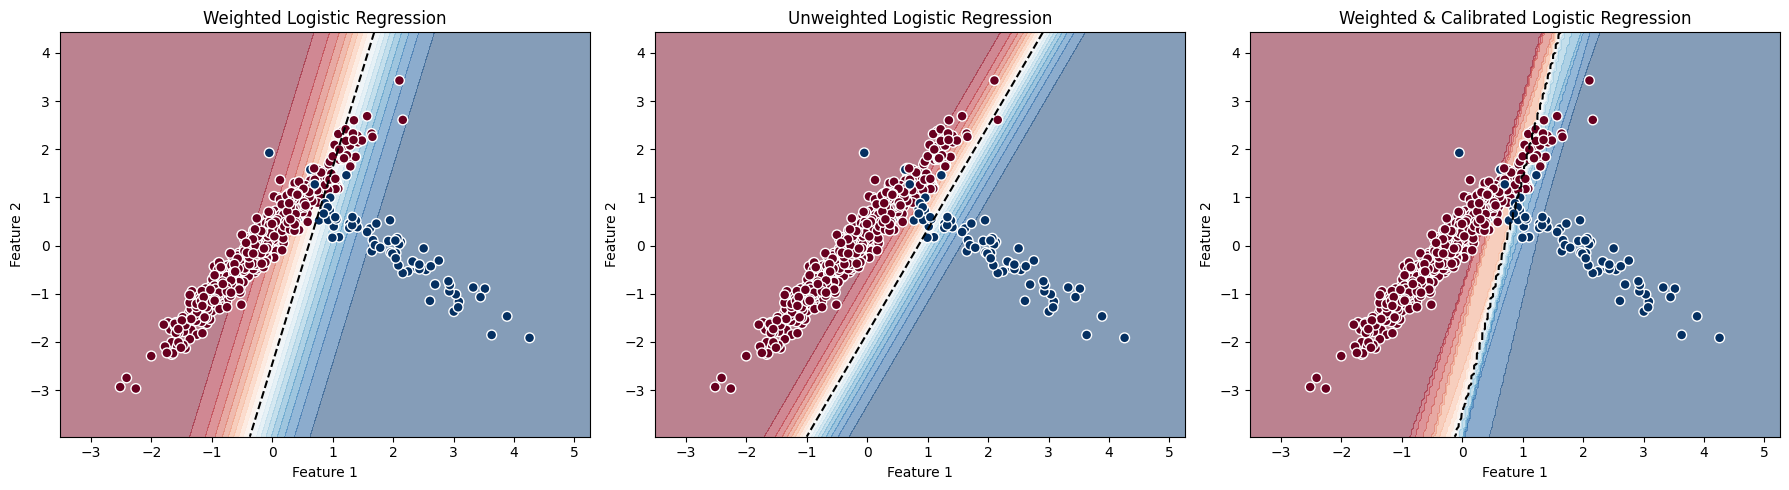

--- Weighted Logistic Regression ---
ROC AUC Score: 0.9596296296296296
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95 27.000000000000114
           1       0.95      0.93      0.94 26.999999999999986

    accuracy                           0.94 54.0000000000001
   macro avg       0.94      0.94      0.94 54.0000000000001
weighted avg       0.94      0.94      0.94 54.0000000000001



--- Unweighted Logistic Regression ---
ROC AUC Score: 0.9598765432098767
Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95 27.000000000000114
           1       1.00      0.90      0.95 26.999999999999986

    accuracy                           0.95 54.0000000000001
   macro avg       0.95      0.95      0.95 54.0000000000001
weighted avg       0.95      0.95      0.95 54.0000000000001



--- Weighted & Calibrated Logistic Regression ---
ROC AUC Score: 0.9630864

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, roc_auc_score

# 1. Create an imbalanced dataset with 2 features
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2,
                           n_redundant=0, n_clusters_per_class=1, 
                           weights=[0.9, 0.1], flip_y=0, random_state=42)

# 2. Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                    test_size=0.3, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Compute sample weights for training based on class imbalance
ratio_0_train = pd.Series(y_train).value_counts(normalize=True)[0]
ratio_1_train = pd.Series(y_train).value_counts(normalize=True)[1]
sample_weight_train = pd.Series(y_train).replace({0: ratio_1_train, 1: ratio_0_train}).values

ratio_0_test = pd.Series(y_test).value_counts(normalize=True)[0]
ratio_1_test = pd.Series(y_test).value_counts(normalize=True)[1]
sample_weight_test = pd.Series(y_test).replace({0: ratio_1_test, 1: ratio_0_test}).values

# 4. Train three logistic regression models

# (A) Weighted Logistic Regression
model_weighted = LogisticRegression(random_state=42, solver='lbfgs', max_iter=5000)
model_weighted.fit(X_train_scaled, y_train, sample_weight=sample_weight_train)

# (B) Unweighted Logistic Regression
model_unweighted = LogisticRegression(random_state=42, solver='lbfgs', max_iter=5000)
model_unweighted.fit(X_train_scaled, y_train)

# (C) Weighted and Calibrated Logistic Regression
base_model = LogisticRegression(random_state=42, solver='lbfgs', max_iter=5000)
base_model.fit(X_train_scaled, y_train, sample_weight=sample_weight_train)
# Calibrate using isotonic regression. Note: With cv=5, the calibrated classifier is an ensemble.
calibrated_model = CalibratedClassifierCV(base_model, method='isotonic', cv=5)
calibrated_model.fit(X_train_scaled, y_train, sample_weight=sample_weight_train)

# 5. Function to plot decision boundaries
def plot_decision_boundary(model, X, y, ax, title):
    # Define a mesh grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    # Predict probabilities for the mesh grid
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = model.predict_proba(grid)[:, 1].reshape(xx.shape)
    
    # Plot contour of predicted probabilities and the decision boundary at 0.5
    ax.contourf(xx, yy, probs, alpha=0.5, cmap=plt.cm.RdBu, levels=np.linspace(0, 1, 20))
    ax.contour(xx, yy, probs, levels=[0.5], linestyles='--', colors='k')
    
    # Scatter plot of the training data
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu, edgecolor='white', s=50)
    ax.set_title(title)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    return ax

# 6. Plot decision boundaries for all three models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plot_decision_boundary(model_weighted, X_train_scaled, y_train, axes[0], "Weighted Logistic Regression")
plot_decision_boundary(model_unweighted, X_train_scaled, y_train, axes[1], "Unweighted Logistic Regression")
plot_decision_boundary(calibrated_model, X_train_scaled, y_train, axes[2], "Weighted & Calibrated Logistic Regression")

plt.tight_layout()
plt.show()

# 7. Evaluate the models on the test set
def evaluate_model(model, model_name):
    y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]
    y_pred = (y_pred_prob >= 0.5).astype(int)
    auc = roc_auc_score(y_test, y_pred_prob, sample_weight=sample_weight_test)
    print(f"--- {model_name} ---")
    print("ROC AUC Score:", auc)
    print("Classification Report:")
    print(classification_report(y_test, y_pred, sample_weight=sample_weight_test))
    print("\n")

evaluate_model(model_weighted, "Weighted Logistic Regression")
evaluate_model(model_unweighted, "Unweighted Logistic Regression")
evaluate_model(calibrated_model, "Weighted & Calibrated Logistic Regression")


In [10]:
calibrated_model.calibrated_classifiers_[0].estimator.coef_

array([[ 2.9756235 , -0.84438944]])